# MLGeometry guide

This introduction demonstrates how to use MLGeometry to: 
1. Generate a hypersurface.
2. Build a bihomogeneous neural network.
3. Use the model to compute numerical Calabi-Yau metrics with the embedding method.
4. Plot $\eta$ on a rational curve.

## Configure imports

Import tensorflow_probability to use the L-BFGS optimizer:

In [47]:
import sympy as sp
import tensorflow as tf
import tensorflow.python.keras.backend as K
import tensorflow_probability as tfp

In [48]:
import MLGeometry as mlg
from MLGeometry import bihomoNN as bnn

Import the libraries to plot the $\eta$ on the rational curve (see the last section):

In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Set a random seed (optional)
Some random seed might be bad for numerical calulations. If there are any errors during the training, you may want to try a different seed.

In [50]:
np.random.seed(2)
tf.random.set_seed(2)

## Define a hypersurface
First define a set of coordinates and a function as sympy symbols:

In [51]:
z0, z1, z2, z3, z4 = sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5

Then define a hypersurface as a collection of points which solve the equation f = 0, using the `Hypersurface` class in the `mlg.hypersurface` module. The parameter n_pairs is the number of random pairs of points used to form the random lines in $\mathbf{CP}^{N+1}$. Then we take the intersections of those random lines and the hypersurface. By Bezout's theorem, each line intersects the hypersurface in precisely d points where d is the number of homogeneous coordinates. So the total number of points is d * n_pairs.

In [52]:
n_pairs = 10000
HS_train = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
HS_test = mlg.hypersurface.Hypersurface(Z, f, n_pairs)

The Hypersurface class will take care of the patchwork automatically. Let's use the `list_patches` function to check the number of points on each patch:

In [53]:
HS_train.list_patches()

Number of Patches: 5
Points on patch 1 : 9916
Points on patch 2 : 10014
Points on patch 3 : 10089
Points on patch 4 : 10130
Points on patch 5 : 9851


You can also invoke this method on one of the patches to check the distribution on the subpatches:

In [54]:
HS_train.patches[0].list_patches()

Number of Patches: 4
Points on patch 1 : 2499
Points on patch 2 : 2474
Points on patch 3 : 2510
Points on patch 4 : 2433


The Hypersurface class contains some symbolic and numerical methods as well, which will be introduced elsewhere. 

## Training with Tensorflow
The following steps are similar to a regular Tensorflow training process. 
### Generate datasets
The `mlg.tf_dataset.generate_dataset` function converts a hypersurface to a Tensorflow Dataset, which has four componets: the points on the hypersurface, the volume form $\small \Omega \wedge \bar\Omega$, the mass reweighting the points distribution and the restriction which restricts the Kähler metric to a subpatch. The restriction contains an extra linear transformation so that points on different affine patches can all be processed in one call. It is also possible to generate a dataset only on one affine patch. 

In [55]:
train_set = mlg.tf_dataset.generate_dataset(HS_train)
test_set = mlg.tf_dataset.generate_dataset(HS_test)

Shuffle and batch the datasets:

In [56]:
train_set = train_set.shuffle(HS_train.n_points).batch(1000)
test_set = test_set.shuffle(HS_test.n_points).batch(1000)

Let's look at what is inside a dataset:

In [57]:
points, Omega_Omegabar, mass, restriction = next(iter(train_set))
print(points)

tf.Tensor(
[[ 0.80762416+5.8595783e-01j -0.2046299 +4.2526782e-01j
  -0.27987286-2.9970634e-01j  1.        +0.0000000e+00j
   0.02055173+2.8625596e-01j]
 [ 0.2214398 -4.7619096e-03j -0.8837117 +1.2649949e-02j
   0.09670468-1.9736986e-01j  0.68551564+5.1580006e-01j
   1.        +0.0000000e+00j]
 [-0.02905042+8.7372251e-03j  0.55520564+5.6939960e-01j
  -0.35768172-8.9537370e-01j  0.47331655-1.5804677e-01j
   1.        -0.0000000e+00j]
 ...
 [-0.6318614 +1.4737147e-01j  0.5048313 +3.0021727e-01j
  -0.4256937 -1.5699993e-01j -0.27833492-9.3904191e-01j
   1.        -0.0000000e+00j]
 [-0.37161765-9.2468965e-01j  1.        -3.8581511e-18j
   0.12969138+6.5817344e-01j  0.77068365-3.3978808e-01j
   0.51064616-1.0733059e-01j]
 [-0.88928723+1.4012744e-01j  0.5028839 +3.1952298e-01j
   1.        -0.0000000e+00j -0.44867373+8.2935357e-01j
  -0.36833343-5.8387405e-01j]], shape=(1000, 5), dtype=complex64)


### Build a bihomogeneous neural network

The `mlg.bihomoNN` module provides the necessary layers (e.g. `Bihomogeneous` and `Dense` ) to construct the Kähler potential with a bihomogeneous neural network. Here is an example of a two-hidden-layer network (k = 4) with 70 and 100 hidden units:

In [58]:
class Kahler_potential(tf.keras.Model):
    def __init__(self):
        super(Kahler_potential, self).__init__()
        # The first layer transforms the complex points to the bihomogeneous form.
        # The number of the outputs is d^2, where d is the number of coordinates.
        self.bihomogeneous = bnn.Bihomogeneous(d=5)
        self.layer1 = bnn.Dense(5**2, 70, activation=tf.square)
        self.layer2 = bnn.Dense(70, 100, activation=tf.square)
        self.layer3 = bnn.Dense(100, 1)
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = tf.math.log(x)
        return x

In [59]:
model = Kahler_potential()

Define the Kähler metric $g_{i \bar j} = \partial_i\bar\partial_{\bar j} K$ and the volume form $d\mu_g = \det g_{i \bar j}$:

In [60]:
@tf.function
def volume_form(points, Omega_Omegabar, mass, restriction):
    
    kahler_metric = mlg.complex_math.complex_hessian(tf.math.real(model(points)), points)
    volume_form = tf.matmul(restriction, tf.matmul(kahler_metric, restriction, adjoint_b=True))
    volume_form = tf.math.real(tf.linalg.det(volume_form))
    
    # Calculate the normalization constant to make the overall integration as 1
    # It is a batchwise calculation but we expect it to converge to a constant eventually
    weights = mass / tf.reduce_sum(mass)
    factor = tf.reduce_sum(weights * volume_form / Omega_Omegabar)
    
    return volume_form / factor

### Train the model with Adam and L-BFGS
#### Adam
Setup the keras optmizer as `Adam` and the loss function as one of weighted loss in the `mlg.loss` module. Some available functions are `weighted_MAPE`, `weighted_MSE`, `max_error` and `MAPE_plus_max_error`. They are weighted with the mass formula since the points on the hypersurface are distributed according to the Fubini-Study measure while the measure used in the integration is determined by the volume form $\small \Omega \wedge \bar\Omega$.

In [61]:
optimizer = tf.keras.optimizers.Adam()
loss_func = mlg.loss.weighted_MAPE

Loop over the batches and train the network:

In [62]:
max_epochs = 500
epoch = 0
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        with tf.GradientTape() as tape:
            det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
            loss = loss_func(Omega_Omegabar, det_omega, mass)
            grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    if epoch % 50 == 0:
        print("epoch %d: loss = %.5f" % (epoch, loss))

epoch 50: loss = 0.43853
epoch 100: loss = 0.11986
epoch 150: loss = 0.05326
epoch 200: loss = 0.05053
epoch 250: loss = 0.04337
epoch 300: loss = 0.00789
epoch 350: loss = 0.00697
epoch 400: loss = 0.00694
epoch 450: loss = 0.00720
epoch 500: loss = 0.00706


Let's check the loss of the test dataset. First define a function to calculate the total loss over the whole dataset:

In [63]:
def cal_total_loss(dataset, loss_function):
    total_loss = tf.constant(0, dtype=tf.float32)
    total_mass = tf.constant(0, dtype=tf.float32)
    
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(dataset):
        det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
        mass_sum = tf.reduce_sum(mass)
        total_loss += loss_function(Omega_Omegabar, det_omega, mass) * mass_sum
        total_mass += mass_sum
    total_loss = total_loss / total_mass

    return total_loss.numpy()

def cal_max_loss(dataset):
    max_loss = tf.constant(0, dtype=tf.float32)
    total_loss = tf.constant(0, dtype=tf.float32)
    total_mass = tf.constant(0, dtype=tf.float32)
    
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(dataset):
        det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
        batch_max = tf.reduce_max(K.abs(Omega_Omegabar - det_omega))
        max_loss = tf.math.maximum(max_loss, batch_max)
        
        mass_sum = tf.reduce_sum(mass)
        total_mass += mass_sum
        
    return max_loss, total_mass

Check the results of MAPE and MSE and max loss:

In [64]:
sigma_test = cal_total_loss(test_set, mlg.loss.weighted_MAPE)
E_test = cal_total_loss(test_set, mlg.loss.weighted_MSE)
print("sigma_test = %.5f" % sigma_test)
print("E_test = %.5f" % E_test)

print(f'max loss={cal_max_loss(test_set)[0]}')
print(f'total volume={cal_max_loss(test_set)[1]/(5*n_pairs)}')
print(f'Normalised max={cal_max_loss(test_set)[0]/(cal_max_loss(test_set)[1]/(5*n_pairs))}')

sigma_test = 0.00707
E_test = 0.00010
max loss=0.008226972073316574
total volume=1.8238965272903442
Normalised max=0.0045300316996872425


You can also check the error of the Monte Carlo integration, estimated by: 

$$\delta \sigma = \frac{1}{\sqrt{N_p}} {\left( \int_X (|\eta - 1_X| - \sigma)^2 d\mu_{\Omega}\right)}^{1/2},$$

where $N_p$ is the number of points on the hypersurface and $\sigma$ is the `weighted_MAPE` loss, and 

$$\eta = \frac{\det \omega}{\small \Omega \wedge \bar \Omega}$$

In [65]:
def delta_sigma_square_test(y_true, y_pred, mass):
    weights = mass / K.sum(mass)
    return K.sum((K.abs(y_true - y_pred) / y_true - sigma_test)**2 * weights)

delta_sigma = cal_total_loss(test_set, delta_sigma_square_test)
print("delta_simga = %.5f" % delta_sigma)

delta_simga = 0.00005


#### Save and Load
The trained network can be saved by:

In [66]:
model.save('trained_model/70_100_1')

INFO:tensorflow:Assets written to: trained_model/70_100_1/assets


INFO:tensorflow:Assets written to: trained_model/70_100_1/assets


And loaded by the `load_model` method:

In [67]:
#model = tf.keras.models.load_model('trained_model/70_100_1', compile=False)

#### L-BFGS
As elaborated in our paper, when the network getting more complicated, L-BFGS converges faster than Adam near the minima. It is recommanded to use it after pretraining with Adam. However, L-BFGS is not in the standard Tensorflow library so the training process is slightly different: (Only ~20 iterations are shown here. In a real case you may want to set the `max_epochs` to ~1000)

In [68]:
# The displayed max_epochs will be three to four times this value since iter + 1 everytime the function
# is invoked, which also happens during the evaluation of the function itself and its gradient
max_epochs = 1000

# Setup the function to be optimized by L-BFGS

train_func = mlg.lbfgs.function_factory(model, loss_func, train_set)

# Setup the inital values and train
init_params = tf.dynamic_stitch(train_func.idx, model.trainable_variables)
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=train_func,
                                        initial_position=init_params,
                                        max_iterations=max_epochs)
# Update the model after the last loop
train_func.assign_new_model_parameters(results.position)

Iter: 1 loss: 0.00700516626
Iter: 2 loss: 1.98779297
Iter: 3 loss: 0.766455591
Iter: 4 loss: 0.0453626364
Iter: 5 loss: 0.0122156749
Iter: 6 loss: 0.00665285904
Iter: 7 loss: 0.00626079
Iter: 8 loss: 0.00920675695
Iter: 9 loss: 0.00625040056
Iter: 10 loss: 0.00612382963
Iter: 11 loss: 0.00613628235
Iter: 12 loss: 0.00602696091
Iter: 13 loss: 0.00594617287
Iter: 14 loss: 0.00620626658
Iter: 15 loss: 0.00592252612
Iter: 16 loss: 0.0058701206
Iter: 17 loss: 0.00601791963
Iter: 18 loss: 0.00585523574
Iter: 19 loss: 0.005828097
Iter: 20 loss: 0.00623617973
Iter: 21 loss: 0.00582748884
Iter: 22 loss: 0.00581409
Iter: 23 loss: 0.00581166893
Iter: 24 loss: 0.00580492
Iter: 25 loss: 0.00579302851
Iter: 26 loss: 0.00585940434
Iter: 27 loss: 0.00578969717
Iter: 28 loss: 0.00578353228
Iter: 29 loss: 0.00578250317
Iter: 30 loss: 0.00578159094
Iter: 31 loss: 0.00577903725
Iter: 32 loss: 0.00577739207
Iter: 33 loss: 0.00577139063
Iter: 34 loss: 0.00579271698
Iter: 35 loss: 0.00576991029
Iter: 36 loss

Note that the definition of the volume form is already in the `mlg.lbfgs` module. Also note that the standard L-BFGS does not support multi-batch training. You can still batch the dataset in case the GPU is out of memory, but the parameters are only updated after a whole epoch. 

You can also check the test dataset:

In [69]:
sigma_test = cal_total_loss(test_set, mlg.loss.weighted_MAPE)
E_test = cal_total_loss(test_set, mlg.loss.weighted_MSE)
print("sigma_test = %.5f" % sigma_test)
print("E_test = %.5f" % E_test)

print(f'max loss={cal_max_loss(test_set)[0]}')
print(f'total volume={cal_max_loss(test_set)[1]/(5*n_pairs)}')
print(f'Normalised max={cal_max_loss(test_set)[0]/(cal_max_loss(test_set)[1]/(5*n_pairs))}')

sigma_test = 0.00587
E_test = 0.00009
max loss=0.009749285876750946
total volume=1.8238972425460815
Normalised max=0.005358920898288488


### $\eta$ on the rational curve

Now let's retrict our model to a subspace and check the local behavior of $\eta$. With the quintic 3-fold f = 0, we can choose the embedding 

$$(z_0, -z_0, z_1, 0, -z_1),$$

and the local coordinate system defined by $t = z_1 / z_0$. Using shperical coordinates $(\theta, \phi)$, it can be embedded into $\mathbb{R}^3$ by:

$$z_0 = \sin \theta \cos \phi, \qquad z_1= \sin \theta \sin \phi + i \cos \phi$$

So first sample the points on the rational curve:

In [70]:
theta, phi = np.linspace(0.001,np.pi+0.001, 400), np.linspace(0.001, 2*np.pi+0.001, 400)
eps = 0.0001 + 0.0001j

R = []
points_list = []
for j in phi:
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i)) / (math.sin(i)*math.cos(j))
        if np.absolute(t) <= 1:
            # The Bihomogeneous layer will remove the zero entries automatically.
            # So here we add a small number eps to avoid being removed
            points_list.append([1+eps, -1+eps, t+eps, 0+eps, -t+eps])
        else:
            # Use the symmetry:
            points_list.append([1+eps, -1+eps, 1/t+eps, 0+eps, -1/t+eps])

Use this set of points to generate the rational curve with norm_coordinate = z0 and max_grad_coordinate = z1:

In [71]:
rc = mlg.hypersurface.Hypersurface(Z, f, points=points_list, norm_coordinate=0, max_grad_coordinate=0)
rc_dataset = mlg.tf_dataset.generate_dataset(rc).batch(rc.n_points)

Calculate $\eta$:

In [72]:
points, Omega_Omegabar, mass, restriction = next(iter(rc_dataset))
det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
eta = (det_omega / Omega_Omegabar).numpy()

Convert to Cartesian coordinates:

In [73]:
R = eta.reshape(400, 400)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)

Plot the figure:

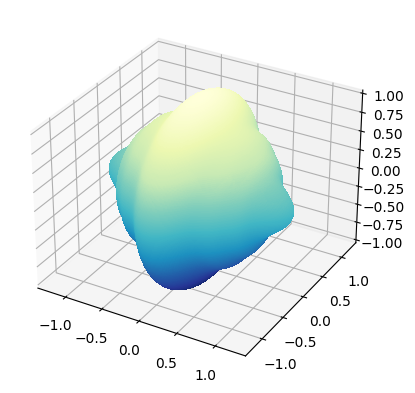

In [74]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_zlim3d(-1.0, 1.0)
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)

$\eta$ is expected to approach the constant function 1 as k increases.